# Recommendation System

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

## Import Data

In [2]:
clean_data = pd.read_csv('../data/cleaned_data.csv')

clean_data.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm,name_processed,assumed_gender,total_of_host_listings_count
0,879181,287172,Central Area,Atlantic,47.60096,-122.30190,Private room,53,30,99,0.80,247,4,jimi hendrix neighborhood 3,female,2
1,6606,14942,Other neighborhoods,Wallingford,47.65444,-122.33629,Entire home/apt,99,30,159,0.95,99,2,fab privat seattl urban cottag,female,3
2,902609,3264544,Delridge,Highland Park,47.52383,-122.35287,Entire home/apt,70,2,238,1.95,206,27,entir guest suit inest seattl,male,5
3,9419,30559,Other neighborhoods,Georgetown,47.55017,-122.31937,Private room,55,2,175,1.14,356,20,gloriou sun room memori foamb,male,9
4,226536,209571,Magnolia,Lawton Park,47.66133,-122.40088,Private room,61,1,316,2.28,209,53,seren room sunni cottag near discoveri park,female,1


**Note:** I plan to use only neighbourhood (or neighbourhood_group), latitude, longitude, room_type, price, minimum_nights, and number_of_reviews since this is variables that are controlled by host. So, they can be knowen prior to buying the property.

In [3]:
data = clean_data[['neighbourhood', 'latitude', 
                   'longitude', 'room_type', 
                   'price', 'minimum_nights',
                   'availability_365', 'host_id']]

data.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,host_id
0,Atlantic,47.60096,-122.30190,Private room,53,30,247,287172
1,Wallingford,47.65444,-122.33629,Entire home/apt,99,30,99,14942
2,Highland Park,47.52383,-122.35287,Entire home/apt,70,2,206,3264544
3,Georgetown,47.55017,-122.31937,Private room,55,2,356,30559
4,Lawton Park,47.66133,-122.40088,Private room,61,1,209,209571


## Feature Enjenering

### 'minimum_nights' Column

In [4]:
data['minimum_nights'].unique()

array([ 30,   2,   1,   3,   4,   5,  10,   7,  25,  60,   6,  14,  31,
       180,   8,  28,  70,  20,  11,  19,  88,  29,  99,  21,  87,  45,
        90,  27,   9,  12,  15,  13])

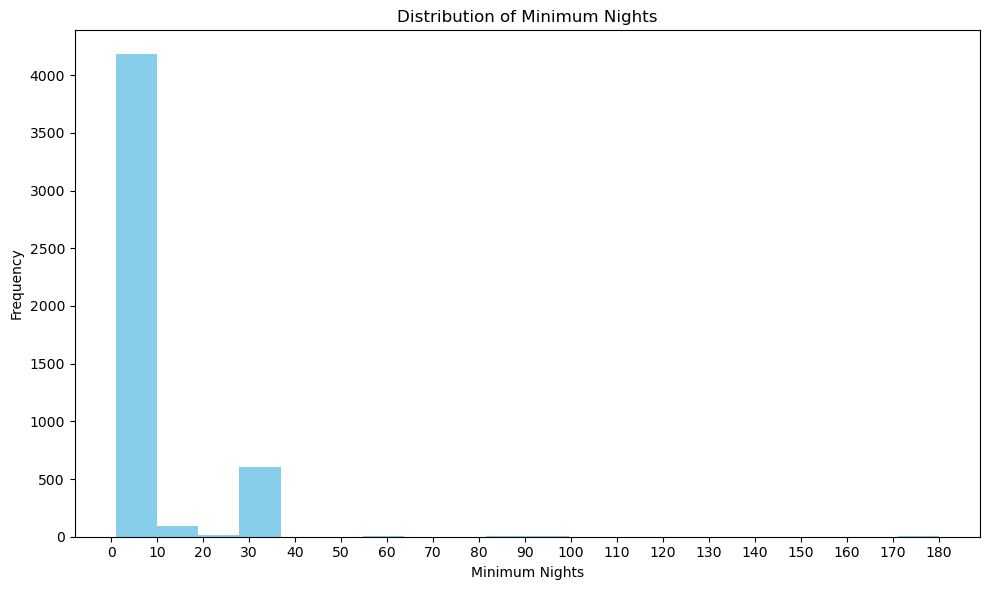

In [5]:
# Plotting the 'minimum_nights' column
plt.figure(figsize = (10, 6))
plt.hist(data['minimum_nights'], bins = 20, color='skyblue')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Nights')
plt.xticks(range(0, 190, 10))
plt.tight_layout()
plt.show()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4917 entries, 0 to 4916
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neighbourhood     4917 non-null   object 
 1   latitude          4917 non-null   float64
 2   longitude         4917 non-null   float64
 3   room_type         4917 non-null   object 
 4   price             4917 non-null   int64  
 5   minimum_nights    4917 non-null   int64  
 6   availability_365  4917 non-null   int64  
 7   host_id           4917 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 307.4+ KB


In [7]:
# Define the conditions and corresponding values for each category
conditions = [
    data['minimum_nights'] == 1,
    data['minimum_nights'] == 2,
    (data['minimum_nights'] > 2) & (data['minimum_nights'] <= 10),
    (data['minimum_nights'] > 10) & (data['minimum_nights'] < 30),
    data['minimum_nights'] == 30,
    (data['minimum_nights'] > 30) & (data['minimum_nights'] < 80),
    (data['minimum_nights'] > 80) & (data['minimum_nights'] <= 100),
    (data['minimum_nights'] > 100) & (data['minimum_nights'] <= 170),
    data['minimum_nights'] > 170
]

values = [
    '1 night',
    '2 nights',
    '10 or less nights',
    '11 to 29 nights',
    '30 nights',
    '31 to under 2 months',
    '2 months',
    'under 6 months (long term)',
    '6 months or more'
]

In [8]:
# Apply the conditions and values to create the new column
data['minimum_nights'] = np.select(conditions, values, default = 'Other')

data['minimum_nights'].value_counts()

/var/folders/xk/4css72c92cl2p_c60yft_4d00000gn/T/ipykernel_40467/845715834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minimum_nights'] = np.select(conditions, values, default = 'Other')


2 nights                1740
1 night                 1420
10 or less nights       1078
30 nights                584
11 to 29 nights           70
2 months                  14
31 to under 2 months       7
6 months or more           4
Name: minimum_nights, dtype: int64

### Adding Income Column

In [9]:
# the goal of the recomendation system is to give recommendations to a future host 
# based on their decired income and availability

# so, create income column
data['income'] = (365 - data['availability_365']) * data['price']

data.head()

/var/folders/xk/4css72c92cl2p_c60yft_4d00000gn/T/ipykernel_40467/3949375209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income'] = (365 - data['availability_365']) * data['price']


,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,host_id,income
0,Atlantic,47.60096,-122.30190,Private room,53,30 nights,247,287172,6254
1,Wallingford,47.65444,-122.33629,Entire home/apt,99,30 nights,99,14942,26334
2,Highland Park,47.52383,-122.35287,Entire home/apt,70,2 nights,206,3264544,11130
3,Georgetown,47.55017,-122.31937,Private room,55,2 nights,356,30559,495
4,Lawton Park,47.66133,-122.40088,Private room,61,1 night,209,209571,9516


## Super Simple Recommendation 

**Note:** I did this to get a better feel of the process and ideas for actual sustem.

In [10]:
data.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,host_id,income
0,Atlantic,47.60096,-122.30190,Private room,53,30 nights,247,287172,6254
1,Wallingford,47.65444,-122.33629,Entire home/apt,99,30 nights,99,14942,26334
2,Highland Park,47.52383,-122.35287,Entire home/apt,70,2 nights,206,3264544,11130
3,Georgetown,47.55017,-122.31937,Private room,55,2 nights,356,30559,495
4,Lawton Park,47.66133,-122.40088,Private room,61,1 night,209,209571,9516


In [11]:
# Step 1: Input - ask user for desired income
desired_income = float(input("Enter your desired income: "))

Enter your desired income:  6254


**Note:** enter existing income to get an output. I used income from row 0: income = 6254.

In [12]:
# Step 2: Ranking
ranked_data = data.sort_values(by = 'income', ascending = False)

In [13]:
# Step 3: Recommendation
recommendations = ranked_data[ranked_data['income'] == desired_income].head(10)

In [14]:
# Display the recommendations
print(f"Top 5 Neighborhood Recommendations:")

recommendations

Top 5 Neighborhood Recommendations:


,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,host_id,income
0,Atlantic,47.60096,-122.3019,Private room,53,30 nights,247,287172,6254


## Recommendation System with for Neighbourhood

**Note:** I did this to undertand the recommendation system setup follwing the code from lesson 7.04.

In [15]:
data.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,host_id,income
0,Atlantic,47.60096,-122.30190,Private room,53,30 nights,247,287172,6254
1,Wallingford,47.65444,-122.33629,Entire home/apt,99,30 nights,99,14942,26334
2,Highland Park,47.52383,-122.35287,Entire home/apt,70,2 nights,206,3264544,11130
3,Georgetown,47.55017,-122.31937,Private room,55,2 nights,356,30559,495
4,Lawton Park,47.66133,-122.40088,Private room,61,1 night,209,209571,9516


#### Create pivot table

In [16]:
pivot = data.pivot_table(values = 'price', index = 'neighbourhood', columns = 'host_id')

pivot.head()

host_id,5887,14942,30559,30832,31280,31481,33360,43811,50201,53050,...,495178517,497644115,497758569,497846107,498123412,498126319,500817107,501872423,502324894,503416528
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139.0,...,NaN,NaN,NaN,NaN,246.0,NaN,NaN,NaN,NaN,NaN
Alki,NaN,NaN,NaN,NaN,NaN,NaN,202.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arbor Heights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Atlantic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belltown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.0,NaN


In [17]:
pivot.shape 

(87, 2900)

#### Create sparse matrix

In [18]:
non_zero_sparse = sparse.csr_matrix(pivot)

In [19]:
sys.getsizeof(non_zero_sparse)

48

In [20]:
print(non_zero_sparse[:20])

  (0, 0)	nan
  (0, 1)	nan
  (0, 2)	nan
  (0, 3)	nan
  (0, 4)	nan
  (0, 5)	nan
  (0, 6)	nan
  (0, 7)	nan
  (0, 8)	nan
  (0, 9)	139.0
  (0, 10)	nan
  (0, 11)	nan
  (0, 12)	nan
  (0, 13)	nan
  (0, 14)	nan
  (0, 15)	nan
  (0, 16)	nan
  (0, 17)	nan
  (0, 18)	nan
  (0, 19)	nan
  (0, 20)	nan
  (0, 21)	nan
  (0, 22)	nan
  (0, 23)	nan
  (0, 24)	108.0
  :	:
  (19, 2875)	nan
  (19, 2876)	nan
  (19, 2877)	nan
  (19, 2878)	nan
  (19, 2879)	nan
  (19, 2880)	nan
  (19, 2881)	nan
  (19, 2882)	nan
  (19, 2883)	nan
  (19, 2884)	nan
  (19, 2885)	nan
  (19, 2886)	nan
  (19, 2887)	nan
  (19, 2888)	nan
  (19, 2889)	nan
  (19, 2890)	nan
  (19, 2891)	nan
  (19, 2892)	nan
  (19, 2893)	nan
  (19, 2894)	nan
  (19, 2895)	nan
  (19, 2896)	nan
  (19, 2897)	nan
  (19, 2898)	nan
  (19, 2899)	nan


In [21]:
pivot_sparse = sparse.csr_matrix(pivot.fillna(0))

In [22]:
sys.getsizeof(pivot)

2024364

In [23]:
sys.getsizeof(pivot_sparse)

48

In [24]:
print(pivot_sparse)

  (0, 9)	139.0
  (0, 24)	108.0
  (0, 66)	100.0
  (0, 182)	119.0
  (0, 195)	282.6666666666667
  (0, 217)	115.0
  (0, 260)	117.0
  (0, 280)	104.5
  (0, 290)	85.5
  (0, 324)	104.0
  (0, 346)	98.0
  (0, 524)	175.0
  (0, 656)	95.0
  (0, 771)	106.0
  (0, 785)	160.0
  (0, 791)	224.0
  (0, 875)	95.0
  (0, 912)	199.0
  (0, 929)	180.0
  (0, 1056)	387.2
  (0, 1129)	156.0
  (0, 1175)	215.0
  (0, 1223)	89.0
  (0, 1250)	95.0
  (0, 1405)	275.0
  :	:
  (84, 1728)	80.0
  (84, 1841)	185.0
  (84, 1906)	77.0
  (84, 2271)	92.0
  (84, 2283)	200.0
  (84, 2479)	72.0
  (84, 2502)	140.0
  (84, 2504)	77.2
  (84, 2562)	114.0
  (84, 2591)	192.0
  (84, 2760)	187.0
  (84, 2780)	164.0
  (85, 861)	204.0
  (85, 1681)	84.0
  (85, 2027)	97.0
  (85, 2591)	185.0
  (85, 2700)	201.0
  (85, 2780)	209.0
  (85, 2835)	169.0
  (86, 365)	76.92857142857143
  (86, 449)	85.0
  (86, 766)	191.0
  (86, 1677)	106.0
  (86, 1932)	127.0
  (86, 2655)	169.0


#### Calculate cosine similarity

In [25]:
distances = pairwise_distances(pivot_sparse, metric = 'cosine')
similarities = 1.0 - distances

similarities.shape

(87, 87)

In [26]:
similarities

array([[1.        , 0.07632202, 0.10644756, ..., 0.06753235, 0.05162384,
        0.        ],
       [0.07632202, 1.        , 0.        , ..., 0.01894203, 0.        ,
        0.        ],
       [0.10644756, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06753235, 0.01894203, 0.        , ..., 1.        , 0.15843065,
        0.        ],
       [0.05162384, 0.        , 0.        , ..., 0.15843065, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

#### Create distances DataFrame

In [27]:
pivot.index[:5]

Index(['Adams', 'Alki', 'Arbor Heights', 'Atlantic', 'Belltown'], dtype='object', name='neighbourhood')

In [28]:
recommender = pd.DataFrame(similarities, index = pivot.index, columns = pivot.index)

recommender.head()

neighbourhood,Adams,Alki,Arbor Heights,Atlantic,Belltown,Bitter Lake,Briarcliff,Brighton,Broadview,Broadway,...,Victory Heights,View Ridge,Wallingford,Wedgwood,West Queen Anne,West Woodland,Westlake,Whittier Heights,Windermere,Yesler Terrace
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Adams,1.000000,0.076322,0.106448,0.102854,0.045716,0.0,0.033317,0.081359,0.0,0.081330,...,0.120381,0.047466,0.037475,0.0,0.091958,0.084339,0.039773,0.067532,0.051624,0.000000
Alki,0.076322,1.000000,0.000000,0.000000,0.074554,0.0,0.000000,0.135418,0.0,0.062254,...,0.146297,0.000000,0.053172,0.0,0.000000,0.012043,0.000000,0.018942,0.000000,0.000000
Arbor Heights,0.106448,0.000000,1.000000,0.102104,0.029845,0.0,0.000000,0.000000,0.0,0.069340,...,0.080319,0.000000,0.029663,0.0,0.093392,0.000000,0.000000,0.000000,0.000000,0.000000
Atlantic,0.102854,0.000000,0.102104,1.000000,0.005803,0.0,0.000000,0.026548,0.0,0.045426,...,0.045602,0.088802,0.023400,0.0,0.062612,0.055512,0.037156,0.023285,0.048227,0.243122
Belltown,0.045716,0.074554,0.029845,0.005803,1.000000,0.0,0.026243,0.068826,0.0,0.068621,...,0.082889,0.047519,0.050110,0.0,0.047973,0.017160,0.038660,0.004296,0.000000,0.036100


#### Evaluate Recommender Performance

In [29]:
q = 'Adams'
queries = data.loc[data['neighbourhood'].str.contains(q), 'neighbourhood'].iloc[0]
recommended = recommender[queries].sort_values(ascending=False)[0:5]

print(queries)
print(recommended)

# q = '70'

# for price in data.loc[data['price'].astype(str).str.contains(q), 'price']:
#     print(price)
#     print(recommender[price].sort_values(ascending = False)[1:11])
#     print()
#     break

Adams
neighbourhood
Adams              1.000000
Leschi             0.181045
Eastlake           0.168174
Interbay           0.131327
Victory Heights    0.120381
Name: Adams, dtype: float64


**Note:** You are a rentor looking for a houses based on price. You know about one district but you want to learn more about similar districts based on price. 

So, now the goal is to sudgest proretries in each distric based on a spesific price that the rentor is looking for. To do this, we need to add a second parametor.

## Recommendation System (Hard encoded)

In [30]:
parameter_1 = "neighbourhood"
parameter_2 = "price"
argument_1 = "Highland Park"
argument_2 = 50

pivot = data.pivot_table(values = parameter_2, index = parameter_1, columns = 'host_id')
non_zero_sparse = sparse.csr_matrix(pivot)
pivot_sparse = sparse.csr_matrix(pivot.fillna(0))
distances = pairwise_distances(pivot_sparse, metric = 'cosine')
similarities = 1.0 - distances
recommender = pd.DataFrame(similarities, index = pivot.index, columns = pivot.index)


print("* Recommending listings based on", parameter_1 , " and ", parameter_2, ":")
print()
print()

queries = data.loc[data[parameter_1].str.contains(argument_1), parameter_1].iloc[0]
recommended = recommender[queries].sort_values(ascending = False)[0:3]

for item, similarity in recommended.items():
    filtered = data[data[parameter_1] == item]
    
    print("*********************")
    print("* ", item, ":")
    print("*********************")
    
    recommendations = sorted(filtered.iterrows(), key = lambda x: abs(x[1][parameter_2] - argument_2))[:3]
    
    for index, recommendation in recommendations:
        print(recommendation)
        print("---------------------------------------------------")    

* Recommending listings based on neighbourhood  and  price :


*********************
*  Highland Park :
*********************
neighbourhood       Highland Park
latitude                 47.53183
longitude              -122.35404
room_type            Private room
price                          45
minimum_nights            1 night
availability_365               47
host_id                  13701143
income                      14310
Name: 956, dtype: object
---------------------------------------------------
neighbourhood       Highland Park
latitude                 47.52253
longitude              -122.35399
room_type            Private room
price                          55
minimum_nights           2 nights
availability_365              333
host_id                   3264544
income                       1760
Name: 4155, dtype: object
---------------------------------------------------
neighbourhood       Highland Park
latitude                 47.52309
longitude              -122.35201
room_

## Rrecommendation System (user input) 

**Note:** for practice run used: 
- parameter_1 = "minimum_nights"
- parameter_2 = "price"
- argument_1 = "30"
- argument_2 = 50

In [31]:
def string_input(prompt):
    while True:
        value = input(prompt)
        if isinstance(value, str):
            return value
        else:
            print("Invalid input. Please enter a string.")

In [32]:
parameter_1 = string_input("Write neighbourhood, room_type, or minimum_nights:") # only strings
parameter_2 = string_input("Write price or availability_365: ") # only numeric
argument_1 = string_input("Enter 1st argument of interest: ")
argument_2 = eval(input("Enter 2nd argument of interest: "))  # Using eval() to convert to int or float

pivot = data.pivot_table(values = parameter_2, index = parameter_1, columns = 'host_id')
non_zero_sparse = sparse.csr_matrix(pivot)
pivot_sparse = sparse.csr_matrix(pivot.fillna(0))
distances = pairwise_distances(pivot_sparse, metric = 'cosine')
similarities = 1.0 - distances
recommender = pd.DataFrame(similarities, index = pivot.index, columns = pivot.index)


print("* Recommending listings based on", parameter_1 , " and ", parameter_2, ":")
print()
print()

queries = data.loc[data[parameter_1].str.contains(argument_1), parameter_1].iloc[0]
recommended = recommender[queries].sort_values(ascending = False)[0:3]

for item, similarity in recommended.items():
    filtered = data[data[parameter_1] == item]
    
    print("*********************")
    print("* ", item, ":")
    print("*********************")
    
    recommendations = sorted(filtered.iterrows(), key = lambda x: abs(x[1][parameter_2] - argument_2))[:3]
    
    for index, recommendation in recommendations:
        print(recommendation)
        print("---------------------------------------------------")

Write neighbourhood, room_type, or minimum_nights: minimum_nights
Write price or availability_365:  price
Enter 1st argument of interest:  30
Enter 2nd argument of interest:  50


* Recommending listings based on minimum_nights  and  price :


*********************
*  30 nights :
*********************
neighbourhood         Crown Hill
latitude                 47.7019
longitude             -122.36781
room_type           Private room
price                         50
minimum_nights         30 nights
availability_365             365
host_id                  2438665
income                         0
Name: 51, dtype: object
---------------------------------------------------
neighbourhood       Mid-Beacon Hill
latitude                   47.56641
longitude                -122.31443
room_type              Private room
price                            50
minimum_nights            30 nights
availability_365                104
host_id                     2085820
income                        13050
Name: 1980, dtype: object
---------------------------------------------------
neighbourhood           Atlantic
latitude                47.60152
longitude             -122.30378
roo

## The methodology of the Recommendation System 

1. It takes user input: The system prompts the user to input various parameters:
    - parameter_1: Represents the category of interest (neighbourhood, room_type, or minimum_nights). It should be a string.
    - parameter_2: Represents the specific attribute of interest (price or availability_365). It can be either numeric or string.
    - argument_1: Represents the specific value of the category of interest. It should be a string.
    - argument_2: Represents the specific value of the attribute of interest. It can be either numeric or string.

2. Data Preparation: The code assumes that there is a dataset (data) containing relevant information about listings. This dataset is used to create a pivot table (pivot) based on the selected parameters (parameter_1 and parameter_2). For this Recommendation System, I used cleaned_data.csv. It is a data file that was saved after Initial EDA.


3. Similarity Calculation: The pivot table is transformed into a sparse matrix to calculate the cosine similarity between listings. The similarity matrix (similarities) is created by subtracting the cosine distance matrix (distances) from 1.

4. Recommendation Generation: The code identifies the queries from the dataset that match the selected parameter_1 and argument_1. It then retrieves the most similar listings (recommended) based on the selected queries from the similarity matrix.

5. Sorting and Filtering: For each recommended item, the code filters the dataset (data) to obtain listings with matching parameter_1 values. These listings are then sorted based on the absolute difference between the selected parameter_2 attribute value (x[1][parameter_2]) and the user input argument_2. The top three recommendations with the closest attribute values are selected.

6. Output: The code prints the recommended listings along with their corresponding information, such as neighbourhood, latitude, longitude, room_type, price, minimum_nights, availability_365, id, host_id, and income.

To conclude, the recommendation system leverages the cosine similarity measure to identify listings with similar attributes of interest. It considers both the category (parameter_1) and the specific attribute (parameter_2) selected by the user, allowing for customized recommendations based on the user's preferences.